# MAT3300: Global Populations 2050: Trends and Insights

## Final Project:
*Global population growth and density are key factors shaping economic development, environmental sustainability, and social stability. Understanding and predicting population growth trends is critical for planning in areas such as infrastructure, resource allocation, healthcare, and policy-making. However, population growth is highly variable across countries, influenced by factors like land area, density, and economic development. Accurate forecasting is essential for both rapidly growing countries and those facing population stagnation or decline


## Part 1: Data Analysis and Trend Identification
Analyze the historical data to identify growth patterns and classify countries into categories (e.g., rapid growth, stable, declining) based on trends. Determine which factors (population density, land area, continent, etc.) most significantly influence growth trends.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit

# Load the data
df = pd.read_csv('population_data.csv')

# Display the first few rows and data info
print(df.head())
print(df.info())

   Rank CCA3 Country/Territory           Capital Continent  2022 Population  \
0    36  AFG       Afghanistan             Kabul      Asia         41128771   
1   138  ALB           Albania            Tirana    Europe          2842321   
2    34  DZA           Algeria           Algiers    Africa         44903225   
3   213  ASM    American Samoa         Pago Pago   Oceania            44273   
4   203  AND           Andorra  Andorra la Vella    Europe            79824   

   2020 Population  2015 Population  2010 Population  2000 Population  \
0         38972230         33753499         28189672         19542982   
1          2866849          2882481          2913399          3182021   
2         43451666         39543154         35856344         30774621   
3            46189            51368            54849            58230   
4            77700            71746            71519            66097   

   1990 Population  1980 Population  1970 Population  Area (km²)  \
0         10694796

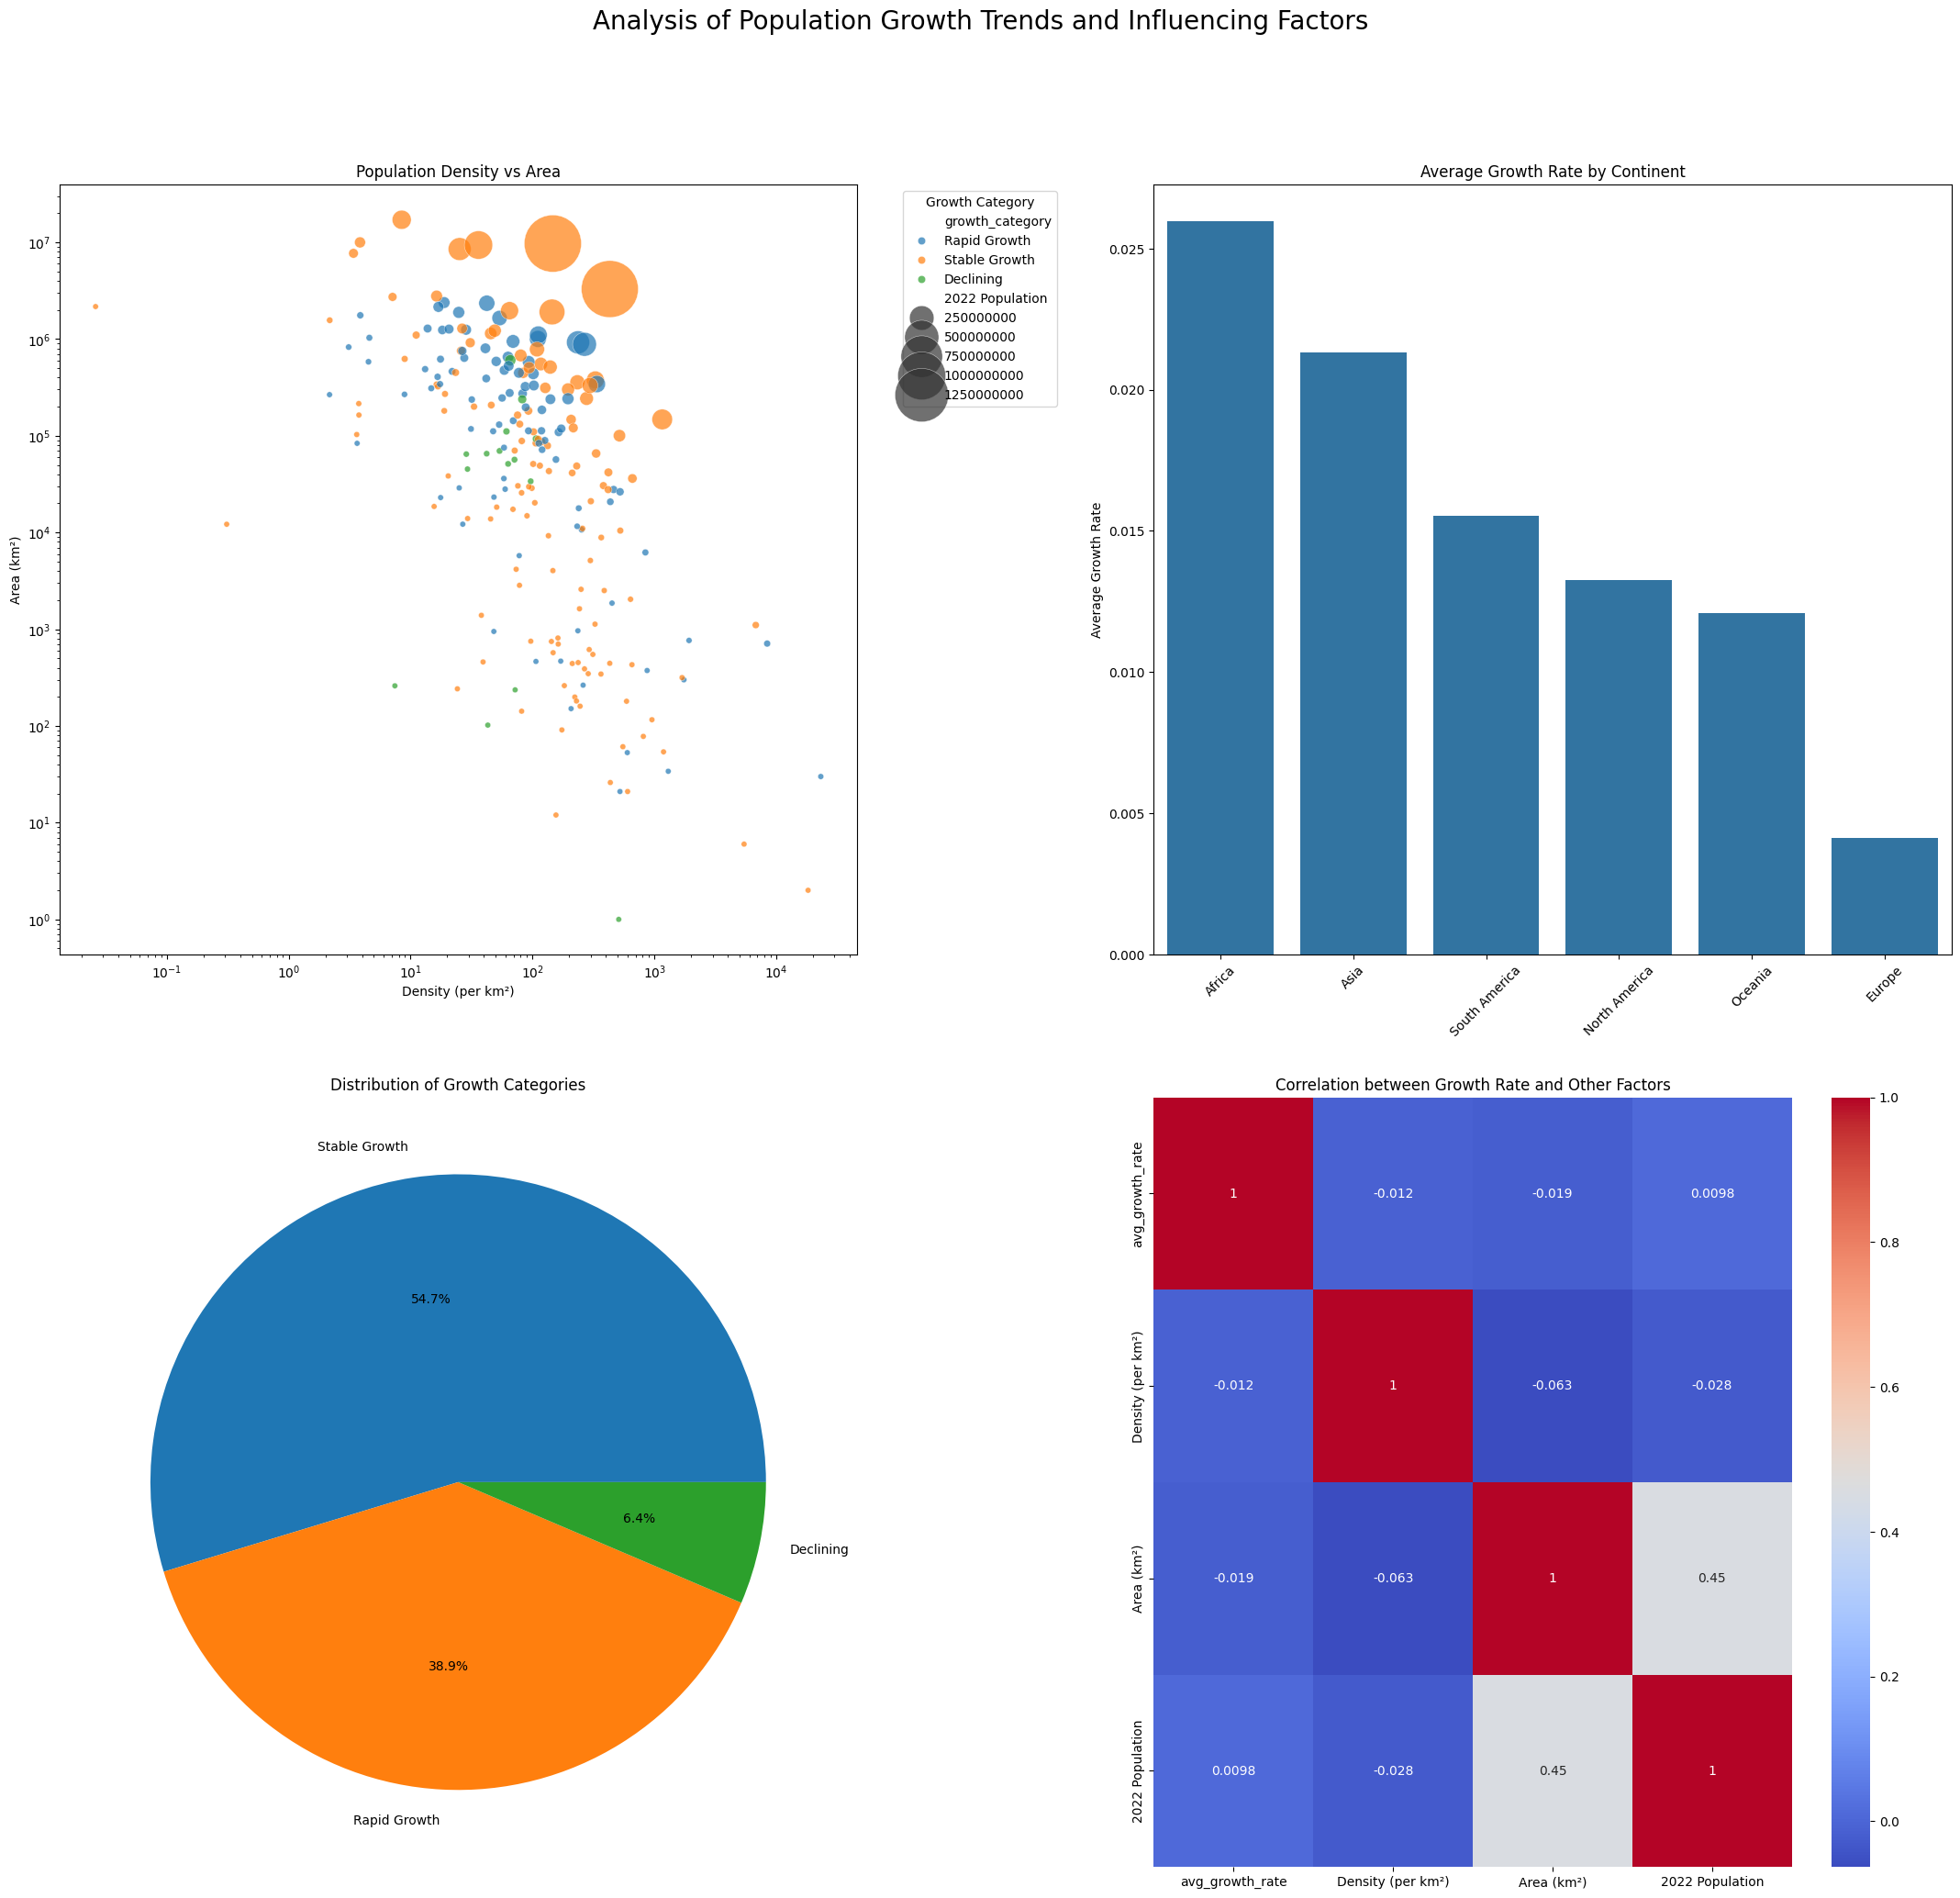


Summary Statistics:
count    234.000000
mean       0.016142
std        0.012477
min       -0.018786
25%        0.005871
50%        0.016343
75%        0.024990
max        0.068709
Name: avg_growth_rate, dtype: float64

Growth Category Distribution:
growth_category
Stable Growth    0.547009
Rapid Growth     0.388889
Declining        0.064103
Name: proportion, dtype: float64

Top 5 Fastest Growing Countries:
            Country/Territory  avg_growth_rate
219      United Arab Emirates         0.068709
167                     Qatar         0.062009
130                   Mayotte         0.043636
215  Turks and Caicos Islands         0.040968
52                   Djibouti         0.040198

Top 5 Fastest Declining Countries:
    Country/Territory  avg_growth_rate
150              Niue        -0.018786
137        Montserrat        -0.018188
226      Vatican City        -0.007440
111            Latvia        -0.004966
73            Georgia        -0.004766


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your dataframe with the necessary data

# Calculate average growth rate between 1970 and 2022
df['avg_growth_rate'] = (df['2022 Population'] / df['1970 Population']) ** (1/52) - 1

# Classify countries based on growth trends
def classify_growth(rate):
    if rate > 0.02:
        return 'Rapid Growth'
    elif rate > 0:
        return 'Stable Growth'
    else:
        return 'Declining'

df['growth_category'] = df['avg_growth_rate'].apply(classify_growth)

# Create a single figure with multiple subplots
fig, axs = plt.subplots(2, 2, figsize=(22, 22))
fig.suptitle('Analysis of Population Growth Trends and Influencing Factors', fontsize=16)

# 1. Scatter plot of Density vs Area, colored by growth category
sns.scatterplot(data=df, x='Density (per km²)', y='Area (km²)', hue='growth_category', 
                size='2022 Population', sizes=(20, 2000), alpha=0.7, ax=axs[0, 0])
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].set_title('Population Density vs Area')
axs[0, 0].legend(title='Growth Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Bar plot of average growth rate by continent
continent_growth = df.groupby('Continent')['avg_growth_rate'].mean().sort_values(ascending=False)
sns.barplot(x=continent_growth.index, y=continent_growth.values, ax=axs[0, 1])
axs[0, 1].set_title('Average Growth Rate by Continent')
axs[0, 1].tick_params(axis='x', rotation=45)
axs[0, 1].set_xlabel('')  # Remove x-axis label as it's redundant
axs[0, 1].set_ylabel('Average Growth Rate')

# 3. Pie chart of growth categories
growth_counts = df['growth_category'].value_counts()
axs[1, 0].pie(growth_counts.values, labels=growth_counts.index, autopct='%1.1f%%')
axs[1, 0].set_title('Distribution of Growth Categories')

# 4. Heatmap of correlation between numerical factors
correlation = df[['avg_growth_rate', 'Density (per km²)', 'Area (km²)', '2022 Population']].corr()
sns.heatmap(correlation, annot=True, ax=axs[1, 1], cmap='coolwarm')
axs[1, 1].set_title('Correlation between Growth Rate and Other Factors')

# Adjust layout
plt.tight_layout(pad=3.0, rect=[0, 0.03, 1, 0.95])

# Add overall title
fig.suptitle('Analysis of Population Growth Trends and Influencing Factors', fontsize=20, y=0.98)

plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(df['avg_growth_rate'].describe())

print("\nGrowth Category Distribution:")
print(df['growth_category'].value_counts(normalize=True))

print("\nTop 5 Fastest Growing Countries:")
print(df.nlargest(5, 'avg_growth_rate')[['Country/Territory', 'avg_growth_rate']])

print("\nTop 5 Fastest Declining Countries:")
print(df.nsmallest(5, 'avg_growth_rate')[['Country/Territory', 'avg_growth_rate']])

## Part 2:  Model Development
Develop a mathematical model or set of models to project population changes from 2022 to 2050 for each country. Consider creating different models for different categories of countries, if needed. If possible, incorporate uncertainty factors such as migration, economic changes, pandemic outbreaks, and potential impacts of global challenges (e.g., climate change).

The logistic growth model is appropriate for population projections, especially over longer time periods.
Uses the formula P(t) = K / (1 + (K/P0 - 1) * e^(-r*t)), where:

K is the carrying capacity
P0 is the initial population
r is the growth rate
t is time
Estimates initial parameters:

P0 is the 1970 population
K (carrying capacity) is initially guessed as twice the current population
r (growth rate) is initially set to 0.02

Uses curve_fit to find the best parameters for each country's data
Includes error handling in case curve_fit fails (e.g., for countries with unusual growth patterns)
Projects population for 2025, 2030, 2035, 2040, 2045, and 2050

In [16]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Load the data
df = pd.read_csv('population_data.csv')

def logistic_growth(t, K, P0, r):
    return K / (1 + (K/P0 - 1) * np.exp(-r * t))

def project_population(row):
    years = np.array([0, 10, 20, 30, 40, 45, 50, 52])  # Years since 1970
    population_data = row[['1970 Population', '1980 Population', '1990 Population', 
                           '2000 Population', '2010 Population', '2015 Population', 
                           '2020 Population', '2022 Population']].values.astype(float)
    
    # Initial guess for parameters
    P0 = population_data[0]
    K = population_data[-1] * 2  # Assume carrying capacity is twice the current population
    r = 0.02
    
    try:
        popt, _ = curve_fit(logistic_growth, years, population_data, p0=[K, P0, r], maxfev=10000)
    except RuntimeError:
        # If curve_fit fails, use a simple linear extrapolation
        growth_rate = (population_data[-1] / population_data[0]) ** (1/52) - 1
        popt = [K, P0, growth_rate]
    
    future_years = np.arange(55, 81, 5)  # 2025, 2030, 2035, 2040, 2045, 2050
    projected_populations = logistic_growth(future_years, *popt)
    
    return pd.Series(projected_populations, index=[f'{1970+year} Projected' for year in future_years])

# Apply the function to each row
projected_df = df.apply(project_population, axis=1)

# Combine with original dataframe
df = pd.concat([df, projected_df], axis=1)

# Display the first few rows of the updated dataframe
print(df.head())

   Rank CCA3 Country/Territory           Capital Continent  2022 Population  \
0    36  AFG       Afghanistan             Kabul      Asia         41128771   
1   138  ALB           Albania            Tirana    Europe          2842321   
2    34  DZA           Algeria           Algiers    Africa         44903225   
3   213  ASM    American Samoa         Pago Pago   Oceania            44273   
4   203  AND           Andorra  Andorra la Vella    Europe            79824   

   2020 Population  2015 Population  2010 Population  2000 Population  ...  \
0         38972230         33753499         28189672         19542982  ...   
1          2866849          2882481          2913399          3182021  ...   
2         43451666         39543154         35856344         30774621  ...   
3            46189            51368            54849            58230  ...   
4            77700            71746            71519            66097  ...   

   Density (per km²)  Growth Rate  World Population Perc

## Part 3: Regional Comparisons

Aggregate, analyze, and visualize population projections at a regional or continental level. Predict the total world population from 2022 to 2050, and analyze the implications of regional differences on global trends.

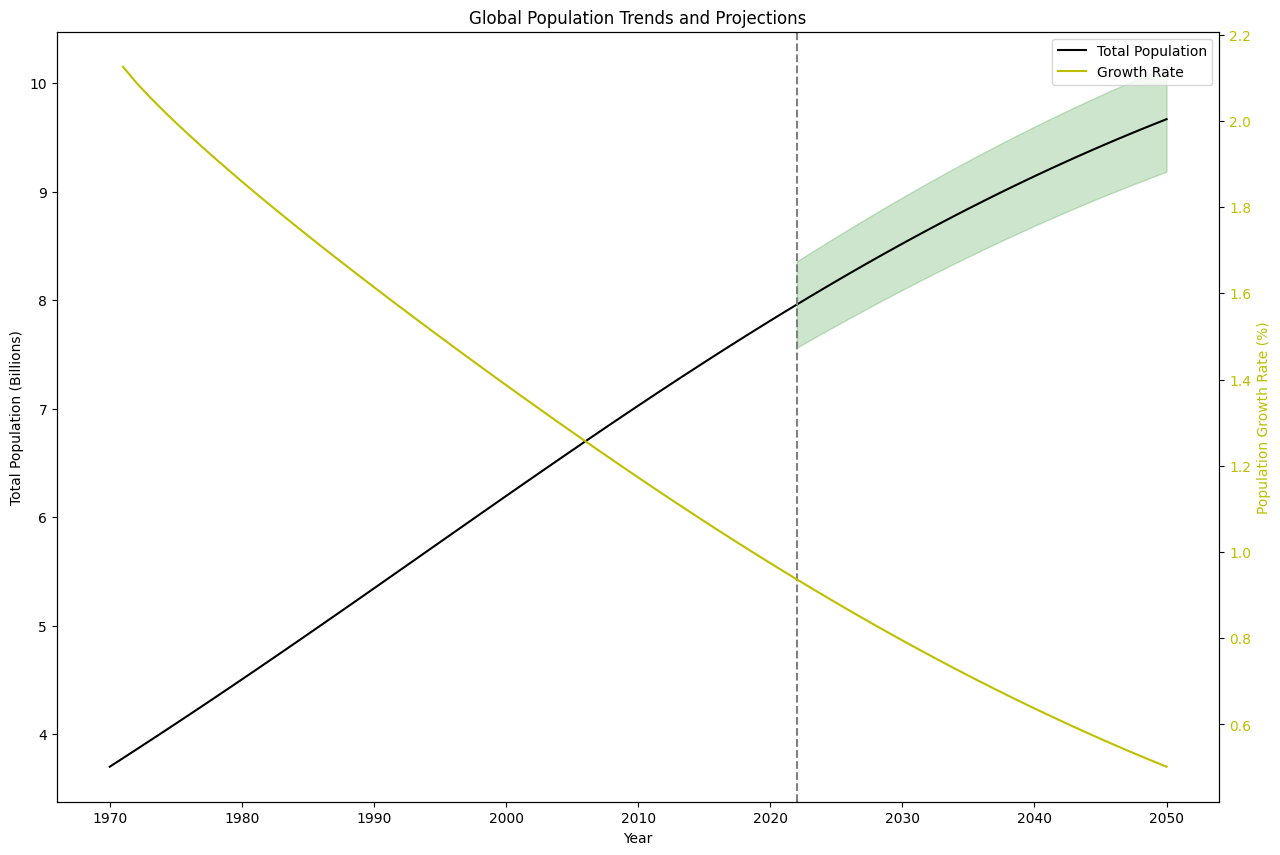

Projected World Population in 2050: 9.67 billion
Projected Annual Growth Rate in 2050: 0.50%


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Create a function for a more stable growth model
def logistic_growth_model(t, P0, K, r):
    return K / (1 + (K/P0 - 1) * np.exp(-r * t))

# Function to project population
def project_population(row):
    years = np.array([0, 10, 20, 30, 40, 45, 50, 52])  # Years since 1970
    population_data = row[['1970 Population', '1980 Population', '1990 Population', 
                           '2000 Population', '2010 Population', '2015 Population', 
                           '2020 Population', '2022 Population']].values.astype(float)
    
    # Initial guesses
    P0 = population_data[0]
    K = max(population_data[-1] * 1.5, P0 * 1.1)  # Ensure K > P0
    r = 0.02
    
    # Set bounds
    lower_bounds = [P0, P0 * 1.05, 0]  # Ensure lower bound of K is greater than P0
    upper_bounds = [P0 * 1.05, K * 2, 1]
    
    try:
        popt, _ = curve_fit(logistic_growth_model, years, population_data, p0=[P0, K, r], 
                            bounds=(lower_bounds, upper_bounds), 
                            maxfev=10000)
    except (RuntimeError, ValueError):
        # If curve_fit fails, use simple linear extrapolation
        growth_rate = (population_data[-1] / population_data[0]) ** (1/52) - 1
        popt = [P0, K, growth_rate]
    
    future_years = np.arange(0, 81, 1)  # 1970 to 2050
    projected_populations = logistic_growth_model(future_years, *popt)
    
    return pd.Series(projected_populations, index=range(1970, 2051))

# Apply the function to each row
projected_df = df.apply(project_population, axis=1)

# Aggregate global population
global_population = projected_df.sum()

# Calculate growth rate
growth_rate = global_population.pct_change()

# Create the visualization
fig, ax1 = plt.subplots(figsize=(15, 10))

# Plot total population
ax1.plot(global_population.index, global_population / 1e9, 'k-', label='Total Population')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Population (Billions)', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Create a second y-axis for growth rate
ax2 = ax1.twinx()
ax2.plot(growth_rate.index[1:], growth_rate[1:] * 100, 'y-', label='Growth Rate')
ax2.set_ylabel('Population Growth Rate (%)', color='y')
ax2.tick_params(axis='y', labelcolor='y')

# Add shaded area for projection uncertainty
projection_start = 2022
ax1.axvline(x=projection_start, color='gray', linestyle='--')
projection_years = global_population.index[global_population.index >= projection_start]
ax1.fill_between(projection_years, 
                 global_population[projection_years] / 1e9 * 0.95, 
                 global_population[projection_years] / 1e9 * 1.05, 
                 color='g', alpha=0.2)

plt.title('Global Population Trends and Projections')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

# Print some statistics
print(f"Projected World Population in 2050: {global_population[2050]/1e9:.2f} billion")
print(f"Projected Annual Growth Rate in 2050: {growth_rate[2050]*100:.2f}%")

## Part 4: Visualization
Create clear visualizations (e.g., graphs, maps) to illustrate key findings, such as projected population changes and regional growth comparison.

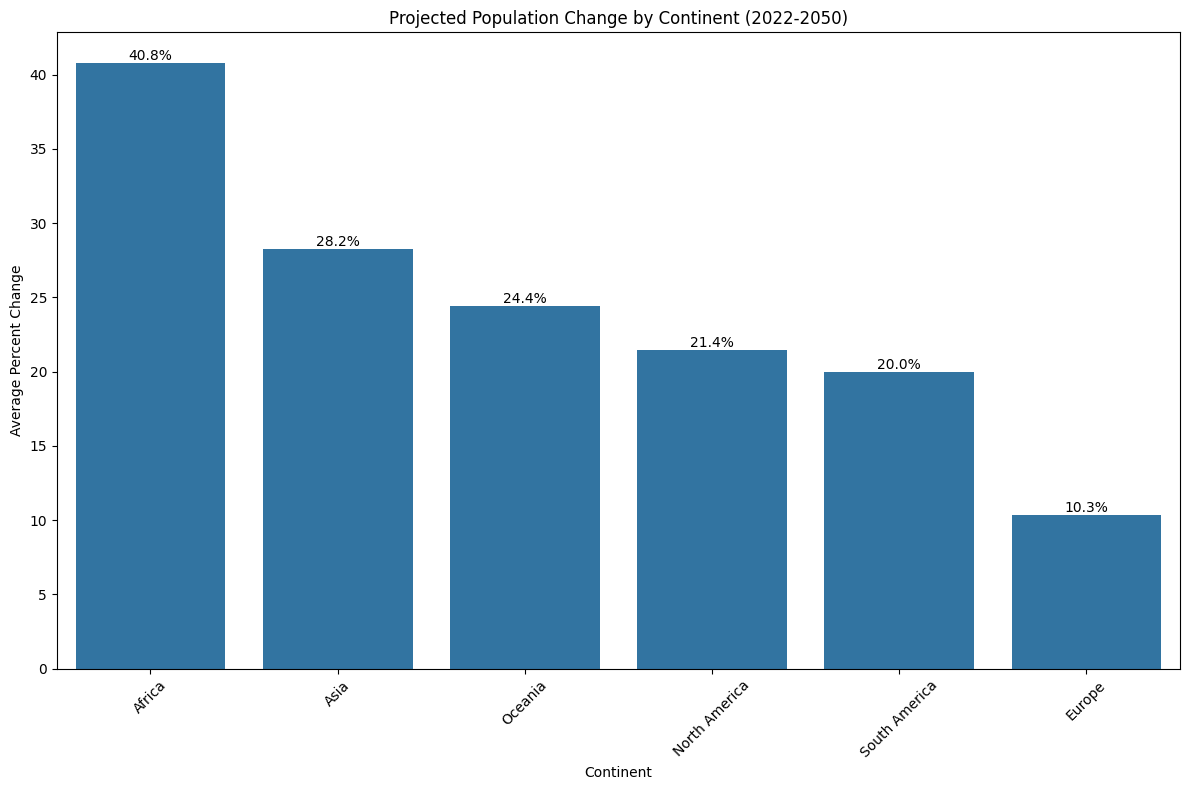

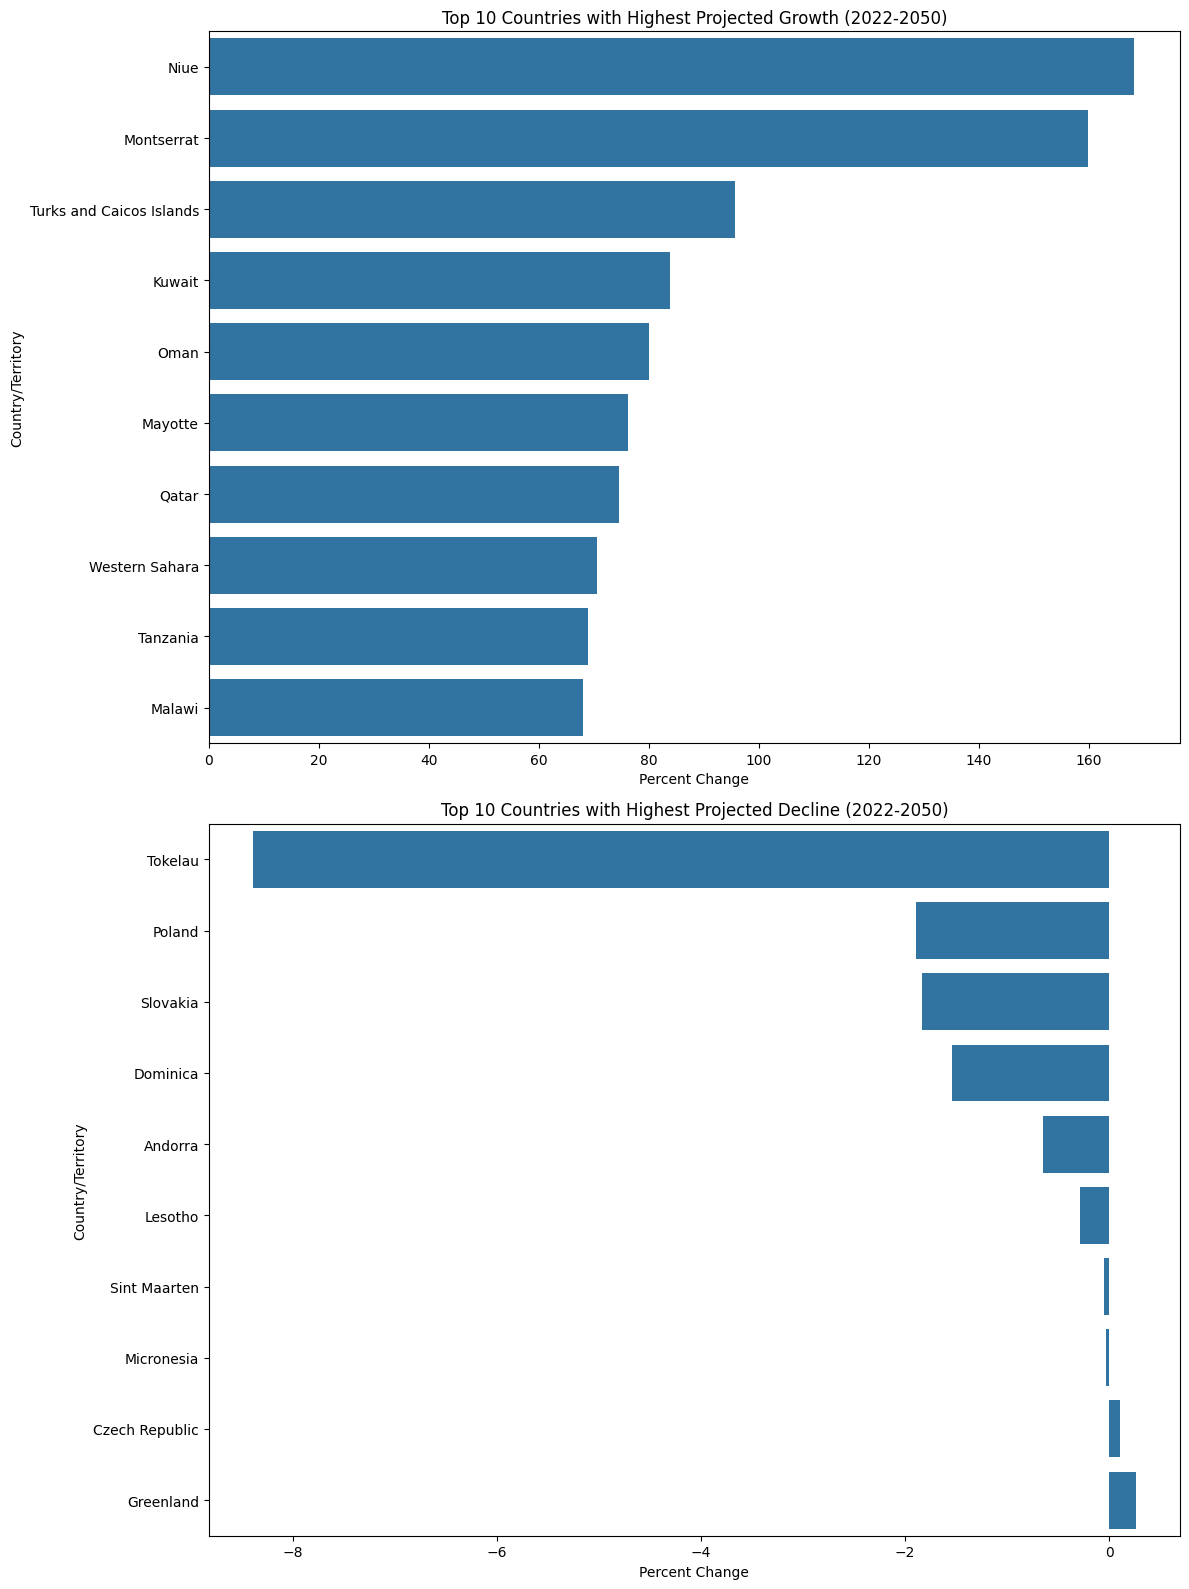

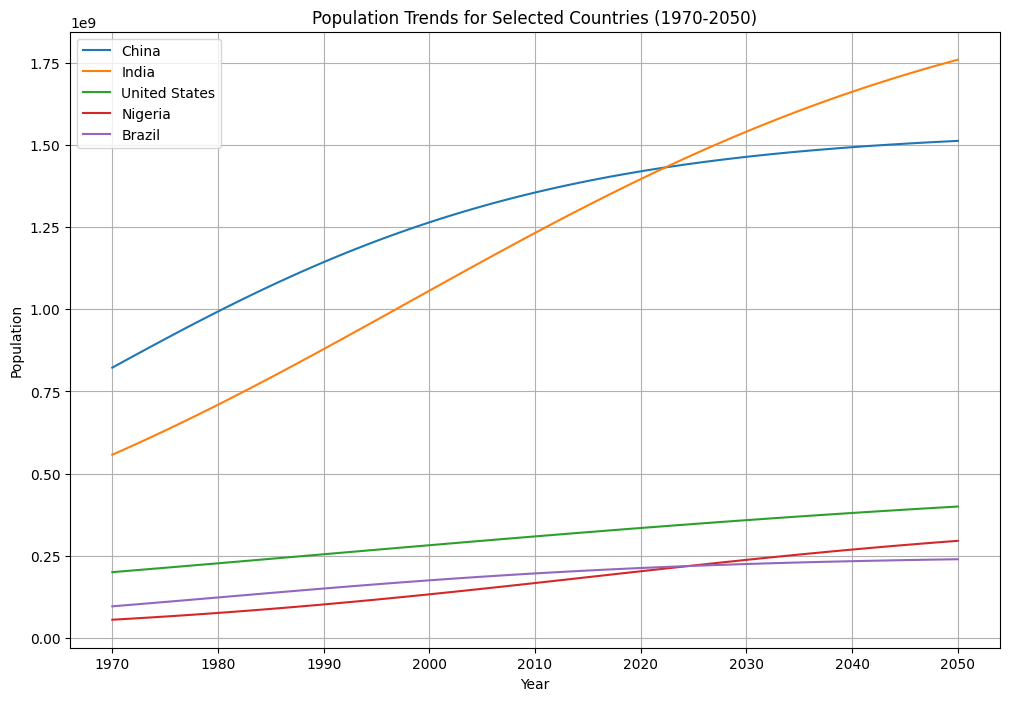

Top 10 countries with highest projected growth:
            Country/Territory  Percent_Change_2022_2050
150                      Niue                168.097208
137                Montserrat                159.726651
215  Turks and Caicos Islands                 95.707358
108                    Kuwait                 83.828862
155                      Oman                 79.978927
130                   Mayotte                 76.225272
167                     Qatar                 74.488509
230            Western Sahara                 70.604946
205                  Tanzania                 68.897463
121                    Malawi                 68.055085

Top 10 countries with highest projected decline:
    Country/Territory  Percent_Change_2022_2050
209           Tokelau                 -8.391235
164            Poland                 -1.891735
189          Slovakia                 -1.838392
53           Dominica                 -1.545150
4             Andorra                 -0.65159

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate percentage change from 2022 to 2050
df['Percent_Change_2022_2050'] = (projected_df[2050] - df['2022 Population']) / df['2022 Population'] * 100

# Group by continent and calculate mean percent change
continent_change = df.groupby('Continent')['Percent_Change_2022_2050'].mean().sort_values(ascending=False)

# Visualization 1: Projected Population Change by Continent
plt.figure(figsize=(12, 8))
sns.barplot(x=continent_change.index, y=continent_change.values)
plt.title('Projected Population Change by Continent (2022-2050)')
plt.xlabel('Continent')
plt.ylabel('Average Percent Change')
plt.xticks(rotation=45)
for i, v in enumerate(continent_change.values):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Top 10 countries with highest growth and decline
top_growth = df.nlargest(10, 'Percent_Change_2022_2050')
top_decline = df.nsmallest(10, 'Percent_Change_2022_2050')

# Visualization 2: Top 10 Countries with Highest Growth and Decline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

sns.barplot(x='Percent_Change_2022_2050', y='Country/Territory', data=top_growth, ax=ax1)
ax1.set_title('Top 10 Countries with Highest Projected Growth (2022-2050)')
ax1.set_xlabel('Percent Change')

sns.barplot(x='Percent_Change_2022_2050', y='Country/Territory', data=top_decline, ax=ax2)
ax2.set_title('Top 10 Countries with Highest Projected Decline (2022-2050)')
ax2.set_xlabel('Percent Change')

plt.tight_layout()
plt.show()

# Visualization 3: Population Trends for Selected Countries
selected_countries = ['China', 'India', 'United States', 'Nigeria', 'Brazil']
plt.figure(figsize=(12, 8))
for country in selected_countries:
    if country in df['Country/Territory'].values:
        country_data = projected_df.loc[df['Country/Territory'] == country].iloc[0]
        plt.plot(country_data.index, country_data.values, label=country)
plt.title('Population Trends for Selected Countries (1970-2050)')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

# Print top 10 countries with highest growth and decline
print("Top 10 countries with highest projected growth:")
print(top_growth[['Country/Territory', 'Percent_Change_2022_2050']])
print("\nTop 10 countries with highest projected decline:")
print(top_decline[['Country/Territory', 'Percent_Change_2022_2050']])